In [79]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


### Process for handling chessData

In [80]:
import pandas as pd
import numpy as np
from chess import Board

from bot_model import evaluator, board2d_embed, bitboard_embed
#from bot_model import limit_val as orginal_limit

limit_val = 160

In [81]:
df = pd.read_csv('data\\random_evals.csv', nrows= 100000)
df.head()

,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209


In [82]:
# mask method
mask = df['Evaluation'].str.contains('#')

# ones with the checkmates
removed_df = df[mask == True]

# normal position
filtered_df = df[mask == False]
filtered_df.head()


,FEN,Evaluation
0,rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1...,-459
1,rnbqkb1r/pppppppp/5n2/1B6/4P3/8/PPPP1PPP/RNBQK...,-125
2,rnbqkbnr/p1pppppp/8/1p6/4P3/8/PPPP1PPP/RNBQKBN...,+198
3,rnbqkb1r/pppppppp/5n2/8/4P3/7N/PPPP1PPP/RNBQKB...,-155
4,rnbqkbnr/ppppp1pp/8/5p2/4P3/8/PPPP1PPP/RNBQKBN...,+209


In [83]:
board_data, targets = None, None

def game_board(fen):
    game = Board(fen)
    return bitboard_embed(game)


# board_data = filtered_df['FEN'].apply(game_board).to_list()
targets = filtered_df['Evaluation'].to_numpy(dtype= int)
print(targets[0:5])

[-459 -125  198 -155  209]


In [84]:
print(f'data_range: {targets.max()} <-> {targets.min()}')
print(f'data_range: {filtered_df.max()} <-> {filtered_df.min()}')

data_range: 9165 <-> -12783
data_range: FEN           rr6/ppp2k1p/3b2p1/3P4/2BR1p2/2P2P1P/PP3P2/2K1R...
Evaluation                                                    0
dtype: object <-> FEN           1B1r1rk1/p4ppp/2p2n2/2q5/2p5/1P3NPb/P1Q2P1P/RN...
Evaluation                                                   +1
dtype: object


In [85]:
removed_df.loc[df['Evaluation'].str.contains('#-'), 'Evaluation'] = str(limit_val * 100)  
removed_df.loc[df['Evaluation'].str.contains('#+'), 'Evaluation'] = str(- limit_val * 100)  
removed_df.head()

C:\Users\anshu_r9i5971\AppData\Local\Temp\ipykernel_12124\3472101051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_df.loc[df['Evaluation'].str.contains('#-'), 'Evaluation'] = str(limit_val * 100)
C:\Users\anshu_r9i5971\AppData\Local\Temp\ipykernel_12124\3472101051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_df.loc[df['Evaluation'].str.contains('#+'), 'Evaluation'] = str(- limit_val * 100)


,FEN,Evaluation
1088,r4rk1/pb2p1bp/6p1/2PqBp2/8/8/1P3PPP/RN1Q1RK1 b...,-16000
1089,r4rk1/pb2p1bp/6p1/B1Pqpp2/8/8/1P3PPP/RN1Q1RK1 ...,-16000
1090,r4rk1/pb2p1bp/6p1/2Pqpp2/3B4/8/1P3PPP/RN1Q1RK1...,-16000
1091,r4rk1/pb2p1bp/6p1/2Pqpp2/1B6/8/1P3PPP/RN1Q1RK1...,-16000
1092,r4rk1/pb2p1bp/6p1/2Pqpp2/8/8/1P1B1PPP/RN1Q1RK1...,-16000


In [86]:
df.loc[df['Evaluation'].str.contains('#-'), 'Evaluation'] = str(limit_val * 100)  
df.loc[df['Evaluation'].str.contains('#+'), 'Evaluation'] = str(-limit_val * 100)  

df['Evaluation'] = pd.to_numeric(df['Evaluation'])

In [87]:
def Robust_Scaling(f = 1):
    median = df['Evaluation'].median()
    iqr = df['Evaluation'].quantile(0.75) - df['Evaluation'].quantile(0.25)

    df['scaled'] = (df['Evaluation'] - median) / iqr * f

def z_score(f = 1):
    df['scaled'] = (df['Evaluation'] - df['Evaluation'].mean()) / df['Evaluation'].std() * f

def min_max_Scaling(f = 10):
    # REJECTED
    df['scaled'] = (df['Evaluation'] - df['Evaluation'].min()) / (df['Evaluation'].max() - df['Evaluation'].min()) * f

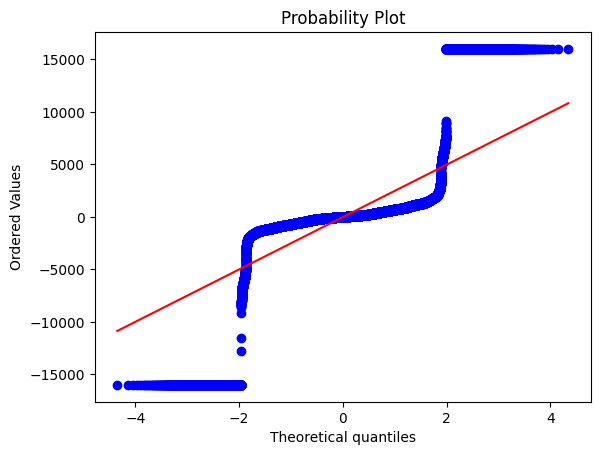

In [88]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(df['Evaluation'], dist="norm", plot=plt)
plt.show()

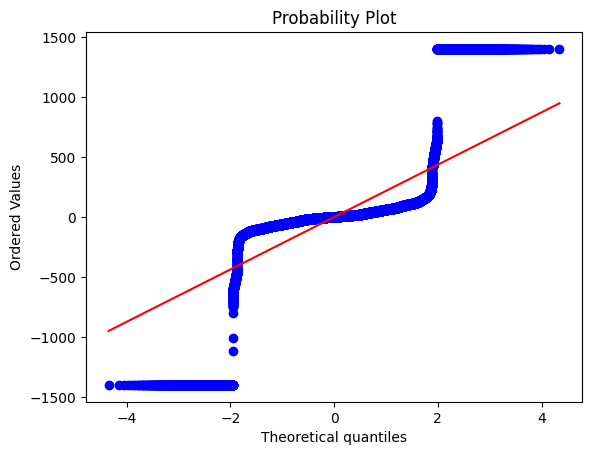

In [89]:
z_score(2 * limit_val)

# Q-Q plot
stats.probplot(df['scaled'], dist="norm", plot=plt)
plt.show()

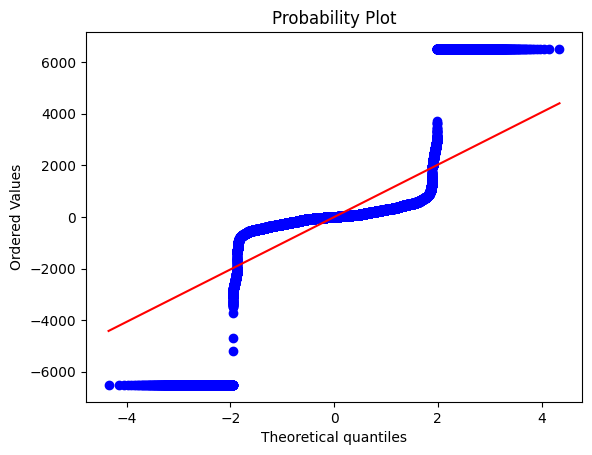

In [90]:
Robust_Scaling(2 * limit_val)

# Q-Q plot
stats.probplot(df['scaled'], dist="norm", plot=plt)
plt.show()

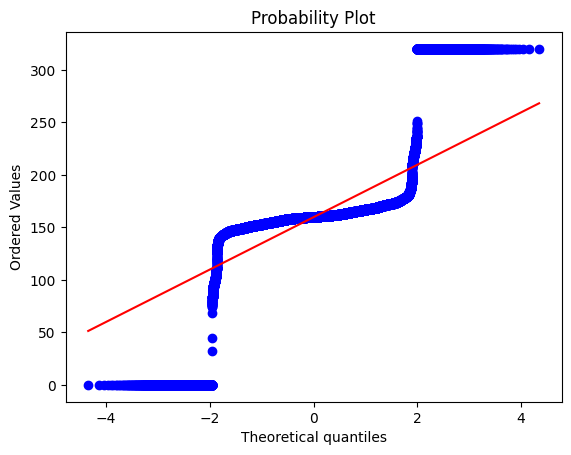

In [91]:
min_max_Scaling(2 * limit_val)

# Q-Q plot
stats.probplot(df['scaled'], dist="norm", plot=plt)
plt.show()

In [92]:
tact_df = pd.read_csv('data\\tactic_evals.csv', nrows= 1000)
tact_df.head()

,FEN,Evaluation,Move
0,r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...,#+2,d3g6
1,r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...,#+1,c2g6
2,r2qkbr1/pb1nn3/1ppp2Bp/8/3P1p2/2P2N1P/PPQN1PP1...,#+1,g8g6
3,8/7p/R5p1/2p1pkP1/7P/P4PK1/1r6/3q4 w - - 6 46,#+1,a6f6
4,6k1/pp6/3p4/2p1p3/2P1P1q1/1P1P2pP/P5P1/5K2 w -...,+408,h3g4


In [93]:
# mask method
mask = tact_df['Evaluation'].str.contains('#')

# normal position
filtered_df = tact_df[mask == False]
filtered_df.head()

,FEN,Evaluation,Move
4,6k1/pp6/3p4/2p1p3/2P1P1q1/1P1P2pP/P5P1/5K2 w -...,+408,h3g4
5,6k1/pp6/3p4/2p1p3/2P1P1bq/1P1P2pP/P3Q1P1/5K2 w...,+444,e2g4
6,6k1/pp6/3p4/2p1p3/2P1P1Qq/1P1P2pP/P5P1/5K2 b -...,+428,h4g4
10,2k4r/pp3pp1/3N1p2/2pP1P1p/b3r1P1/P1P4P/2P5/R1R...,+667,c8c7
12,6k1/pp6/3p4/2p1p3/2P1P1P1/1P1P2p1/P5P1/5K2 b -...,+462,g8f7


In [94]:
targets = filtered_df['Evaluation'].to_numpy(dtype= int)
print(f'data_range: {targets.max()} <-> {targets.min()}')

data_range: 1234 <-> -1732
